In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
import scipy.sparse.linalg as spla
from google.colab import files
from numpy import linalg as LA
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd

In [ ]:
# utility functions
def u_ex(x,mu,beta): return (np.exp(beta*x/mu) - 1)/(np.exp(beta/mu) - 1)
def f(x): return [0]*len(x)



```
# This is formatted as code
```

# Define Functions

In [ ]:
def f_center(a, b, mu, beta, h):
    
    # check if mu is positive
    if mu < 0:
      print('negative mu')
    
    # a and b are left/right boundary points; h is the step change of x
    a, b, mu, beta, h = a, b, mu, beta, h

    # I don't think these two lines are useful in our codes -- Kai
    # uL = u_ex(a,mu,beta)
    # uR = u_ex(b,mu,beta)
    
    # number of steps in the interval
    N = int((b-a)/h)

    # discretize the space
    x = np.linspace(a,b,N+1)

    # omit the end points since they are not considered in our system of equations
    y = x[1:-1]
    
    # the vector b we refered to in our analysis
    ff = f(y)
    
    Ad = -(mu/h**2)*sp.diags([1., -2., 1.], [-1, 0, 1], shape=[N-1, N-1], format = 'csr')
    Ac = beta/(2*h)*sp.diags([-1., 0., 1.], [-1, 0, 1], shape=[N-1, N-1], format = 'csr')

    A = Ad + Ac
    
    # per our analysis, the last entry of ff is 
    ff[-1] = mu/h**2 - beta/(2*h)
    
    # solve the linear system A \ b
    return sp.linalg.spsolve(A, ff)

In [ ]:
# new Upwind Method, i think this is correct. 
def f_upwind(a, b, mu, beta, h):

    # check if mu is positive
    if mu < 0:
      print('negative mu')
    
    # initialize values
    a, b, mu, beta, h = a, b, mu, beta, h
    
    # number of steps in the interval
    N = int((b-a)/h)

    # discretize the space
    x = np.linspace(a,b,N+1)

    # omit the end points since they are not considered in our system of equations
    y = x[1:-1]
    
    # the vector b we refered to in our analysis
    ff = f(y)

    if beta > 0:
        Ad =-(mu/h**2)*sp.diags([1., -2., 1.], [-1, 0, 1], shape=[N-1, N-1], format = 'csr')
        Ac = beta/(h)*sp.diags([-1., 1., 0], [-1, 0, 1], shape=[N-1, N-1], format = 'csr')
        ff[-1] = mu/h**2
    else:
        Ad =-(mu/h**2)*sp.diags([1., -2., 1.], [-1, 0, 1], shape=[N-1, N-1], format = 'csr')
        Ac = beta/(h)*sp.diags([0, -1., 1.], [-1, 0, 1], shape=[N-1, N-1], format = 'csr')
        ff[-1] = mu/h**2 - beta/h
    
    A = Ad + Ac

    return sp.linalg.spsolve(A, ff)

In [ ]:
def f_O2upwind(a,b,mu,beta,h):
  if mu<0:
    print('negative mu')

  a,b,mu,beta,h = a,b,mu,beta,h

  N = int((b-a)/h)

  x = np.linspace(a,b,N+1)
  y = x[1:-1]

  ff = f(y)

  if beta > 0:
    Ad = -(mu/h**2)*sp.diags([1., -2., 1.], [-1, 0, 1], shape = [N-1,N-1], format = 'csr')
    Ac = (beta/h)*sp.diags([1/2, -2, 3/2], [-2, -1, 0], shape = [N-1, N-1], format = 'csr')
    ff[-1] = mu/h**2
    A = Ad+Ac
    A[0,0] = 2*mu/h**2
    A[0,1] = -mu/h**2 + beta/(2*h)
  else:
    Ad = -(mu/h**2)*sp.diags([1., -2., 1.], [-1, 0, 1], shape = [N-1,N-1], format = 'csr')
    Ac = -(beta/h)*sp.diags([3/2, -2, 1/2], [0, 1, 2], shape = [N-1, N-1], format = 'csr')
    A = Ad+Ac
    ff[-1] = mu/h**2 - beta/(2*h)
    A[-1,-1] = 2*mu/h**2
    A[-1, -2] = -mu/h**2 - beta/(2*h)

  return sp.linalg.spsolve(A, ff)

# Centered difference, positive beta

In [ ]:
#Test for center difference using beta postive
a = 0.
b = 1.
mu = 10

error_table = pd.DataFrame(index = ['beta', 'h', 'error']).T
for i in [1, 10, 100, 1000]:
    for j in [0.1, 0.05, 0.025, 0.01, 0.005]:
        temp_u = f_center(a, b, mu, i, j)
        
        temp_N = int((b-a)/j)
        temp_x = np.linspace(a,b,temp_N + 1)
        temp_y = temp_x[1:-1]
        temp_ex = u_ex(temp_y, mu, i)
        
        temp_error = np.max(np.abs(temp_ex - temp_u))
        temp_row = pd.DataFrame([i, j, temp_error], index = error_table.columns).T
        error_table = error_table.append(temp_row)

error_table.loc[:,'Pe'] = (np.abs(error_table.loc[:,'beta']) * error_table.loc[:,'h']) / (2 * mu)
# error_table.to_csv()
error_table

,beta,h,error,Pe
0,1.0,0.100,1.041032e-07,0.00500
0,1.0,0.050,2.602549e-08,0.00250
0,1.0,0.025,6.506356e-09,0.00125
0,1.0,0.010,1.041295e-09,0.00050
0,1.0,0.005,2.603148e-10,0.00025
0,10.0,0.100,1.006860e-04,0.05000
0,10.0,0.050,2.514359e-05,0.02500
0,10.0,0.025,6.291757e-06,0.01250
0,10.0,0.010,1.006797e-06,0.00500
0,10.0,0.005,2.516964e-07,0.00250


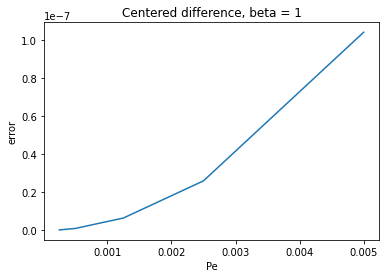

In [ ]:
beta = 1
plt.figure(1)
plt.plot(error_table.loc[[i == beta for i in error_table.beta],'Pe'], error_table.loc[[i == beta for i in error_table.beta],'error'])
plt.xlabel('Pe')
plt.ylabel('error')
plt.title('Centered difference, beta = ' + str(beta))
plt.savefig('352hw2.png')

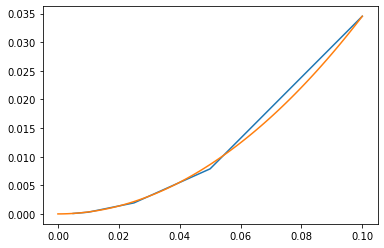

In [ ]:
beta = 100

temp_x = np.linspace(0, max(error_table.loc[[i == beta for i in error_table.beta],'h']), 100)
temp_coef = max(error_table.loc[[i == beta for i in error_table.beta],'error']) / (max(error_table.loc[[i == beta for i in error_table.beta],'h']) ** 2)
temp_y = [temp_coef * (i ** 2) for i in temp_x]
plt.plot(error_table.loc[[i == beta for i in error_table.beta],'h'], error_table.loc[[i == beta for i in error_table.beta],'error'])
plt.plot(temp_x, temp_y)

# Centered difference, negative beta

In [ ]:
#Test for center difference using beta negative
a = 0.
b = 1.
mu = 10

error_table = pd.DataFrame(index = ['beta', 'h', 'error']).T
for i in [-1, -10, -100, -1000]:
    for j in [0.1, 0.05, 0.025, 0.01, 0.005]:
        temp_u = f_center(a, b, mu, i, j)
        
        temp_N = int((b-a)/j)
        temp_x = np.linspace(a,b,temp_N + 1)
        temp_y = temp_x[1:-1]
        temp_ex = u_ex(temp_y, mu, i)
        
        temp_error = np.max(np.abs(temp_ex - temp_u))
        temp_row = pd.DataFrame([i, j, temp_error], index = error_table.columns).T
        error_table = error_table.append(temp_row)
        
#error_table = error_table.dropna(how = 'any')
error_table.loc[:,'Pe'] = (np.abs(error_table.loc[:,'beta']) * error_table.loc[:,'h']) / (2 * mu)
# error_table.loc[:,'% error'] = error_table.loc[:,'error'].div(error_table.groupby('beta')['error'].shift(1))
# error_table.loc[:,'% h'] = error_table.loc[:,'h'].div(error_table.groupby('beta')['h'].shift(1))
error_table

,beta,h,error,Pe
0,-1.0,0.100,1.041032e-07,0.00500
0,-1.0,0.050,2.602550e-08,0.00250
0,-1.0,0.025,6.506355e-09,0.00125
0,-1.0,0.010,1.041294e-09,0.00050
0,-1.0,0.005,2.603306e-10,0.00025
0,-10.0,0.100,1.006860e-04,0.05000
0,-10.0,0.050,2.514359e-05,0.02500
0,-10.0,0.025,6.291757e-06,0.01250
0,-10.0,0.010,1.006797e-06,0.00500
0,-10.0,0.005,2.516964e-07,0.00250


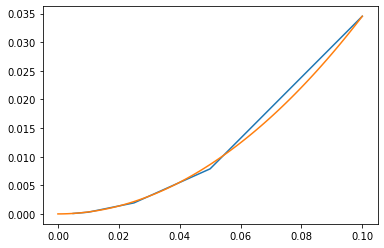

In [ ]:
beta = -100

temp_x = np.linspace(0, max(error_table.loc[[i == beta for i in error_table.beta],'h']), 100)
temp_coef = max(error_table.loc[[i == beta for i in error_table.beta],'error']) / (max(error_table.loc[[i == beta for i in error_table.beta],'h']) ** 2)
temp_y = [temp_coef * (i ** 2) for i in temp_x]
plt.plot(error_table.loc[[i == beta for i in error_table.beta],'h'], error_table.loc[[i == beta for i in error_table.beta],'error'])
plt.plot(temp_x, temp_y)

# Coarsest oscillation test

,beta,h,error,Pe
0,-200.0,0.0001,0.001232,0.1
0,-200.0,0.1000,9.923741,100.0


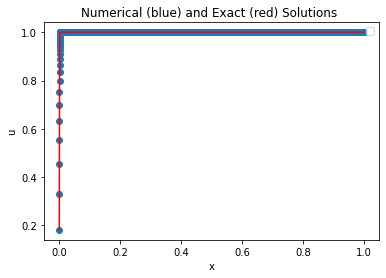

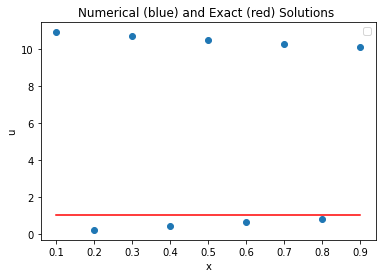

In [ ]:
#Testing for part 3 - oscillations
a = 0.
b = 1.
mu = .1
step = [0.0001, 0.1]
error_table = pd.DataFrame(index = ['beta', 'h', 'error']).T
for i in [-200]:
    for j in range(len(step)):
        beta = step[j]
        temp_u = f_center(a, b, mu, i, beta)
        
        temp_N = int((b-a)/beta)
        temp_x = np.linspace(a,b,temp_N + 1)
        temp_y = temp_x[1:-1]
        temp_ex = u_ex(temp_y, mu, i)
        
        temp_error = np.max(np.abs(temp_ex - temp_u))
        temp_row = pd.DataFrame([i, beta, temp_error], index = error_table.columns).T
        error_table = error_table.append(temp_row)

        title = "Numerical (blue) and Exact (red) Solutions " #+ str(j)
        fig = plt.figure(j)
        plt.plot(temp_y, temp_ex, color="red")
        plt.scatter(temp_y, temp_u)
        plt.legend("","")
        plt.title(title) 
        plt.xlabel("x")
        plt.ylabel("u")

        fig.savefig("abc" + str(j) +".png")
        #files.download("abc.png") 

#error_table = error_table.dropna(how = 'any')
error_table.loc[:,'Pe'] = (np.abs(error_table.loc[:,'beta']) * error_table.loc[:,'h']) / (2 * mu)
error_table

# Upwind oscillation check, positive beta

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


,beta,h,error,Pe
0,200.0,0.0001,NaN,0.1
0,200.0,0.1000,NaN,100.0


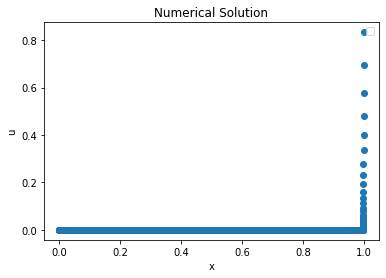

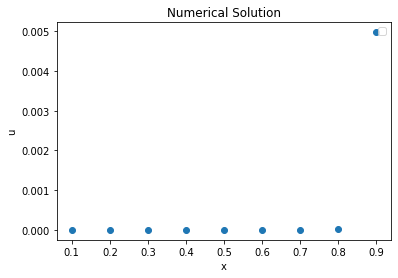

In [ ]:
#Part 4 - Upwind method to check that oscillations are not a problem - positive beta
a = 0.
b = 1.
mu = 0.1
step = [0.0001, 0.1]
error_table = pd.DataFrame(index = ['beta', 'h', 'error']).T
for i in [200]: #a positive beta
    for j in range(len(step)):
        beta = step[j]
        temp_u = f_upwind(a, b, mu, i, beta)
        
        temp_N = int((b-a)/beta)
        temp_x = np.linspace(a,b,temp_N + 1)
        temp_y = temp_x[1:-1]
        temp_ex = u_ex(temp_y, mu, i)
        
        temp_error = np.max(np.abs(temp_ex - temp_u))
        temp_row = pd.DataFrame([i, beta, temp_error], index = error_table.columns).T
        error_table = error_table.append(temp_row)

        title = "Numerical Solution" #+ str(j)
        fig = plt.figure(j)
        #plt.plot(temp_y, temp_ex, color="red")
        plt.scatter(temp_y, temp_u)
        plt.legend("","")
        plt.title(title) 
        plt.xlabel("x")
        plt.ylabel("u")

        fig.savefig("upwindPositiveBeta" + str(j) +".png")
        #files.download("abc.png")

        
#error_table = error_table.dropna(how = 'any')
error_table.loc[:,'Pe'] = (np.abs(error_table.loc[:,'beta']) * error_table.loc[:,'h']) / (2 * mu)
error_table

# Upwind oscillation check, negative beta

,beta,h,error,Pe
0,-200.0,0.0001,0.033998,0.1
0,-200.0,0.1000,0.004975,100.0


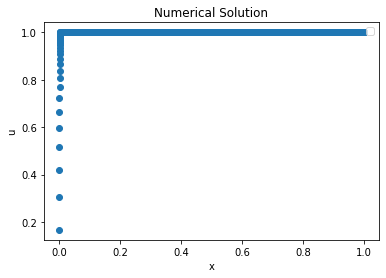

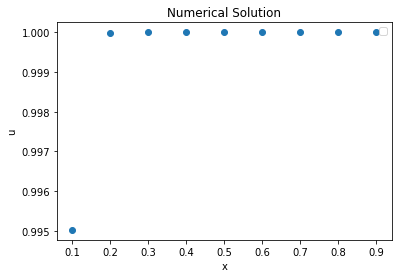

In [ ]:
#Part 4 - Upwind method to check that oscillations are not a problem - negative beta
a = 0.
b = 1.
mu = 0.1
step = [0.0001, 0.1]
error_table = pd.DataFrame(index = ['beta', 'h', 'error']).T
for i in [-200]: #a negative beta
    for j in range(len(step)):
        beta = step[j]
        temp_u = f_upwind(a, b, mu, i, beta)
        
        temp_N = int((b-a)/beta)
        temp_x = np.linspace(a,b,temp_N + 1)
        temp_y = temp_x[1:-1]
        temp_ex = u_ex(temp_y, mu, i)
        
        temp_error = np.max(np.abs(temp_ex - temp_u))
        temp_row = pd.DataFrame([i, beta, temp_error], index = error_table.columns).T
        error_table = error_table.append(temp_row)

        title = "Numerical Solution" #+ str(j)
        fig = plt.figure(j)
        #plt.plot(temp_y, temp_ex, color="red")
        plt.scatter(temp_y, temp_u)
        plt.legend("","")
        plt.title(title) 
        plt.xlabel("x")
        plt.ylabel("u")

        fig.savefig("upwindNegativeBeta" + str(j) +".png")
        #files.download("abc.png")

        
#error_table = error_table.dropna(how = 'any')
error_table.loc[:,'Pe'] = (np.abs(error_table.loc[:,'beta']) * error_table.loc[:,'h']) / (2 * mu)
error_table

# Upwind order check - 1st order

,beta,h,error,Pe
0,-20.0,0.00100,0.003648,0.0100
0,-20.0,0.00050,0.001832,0.0050
0,-20.0,0.00025,0.000918,0.0025


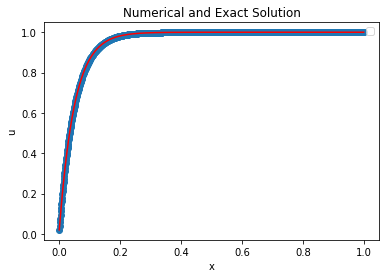

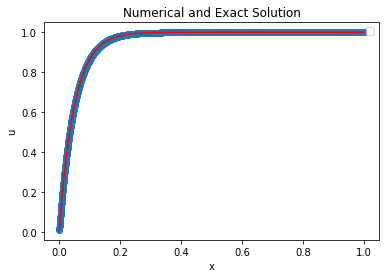

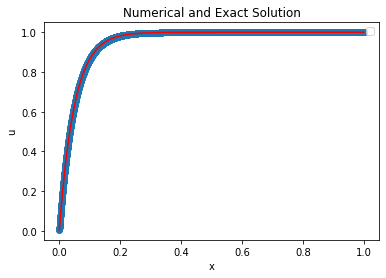

In [ ]:
#Part 5 - Convergence Rate of Upwind method # order 1 apparently
a = 0.
b = 1.
mu = 1
h = 0.001
step = [h, h/2, h/4]
error_table = pd.DataFrame(index = ['beta', 'h', 'error']).T
for i in [-20]: #a negative beta
    for j in range(len(step)):
        beta = step[j]
        temp_u = f_upwind(a, b, mu, i, beta)
        
        temp_N = int((b-a)/beta)
        temp_x = np.linspace(a,b,temp_N + 1)
        temp_y = temp_x[1:-1]
        temp_ex = u_ex(temp_y, mu, i)
        
        temp_error = np.max(np.abs(temp_ex - temp_u))
        temp_row = pd.DataFrame([i, beta, temp_error], index = error_table.columns).T
        error_table = error_table.append(temp_row)

        plt.figure(j)
        plt.plot(temp_y, temp_ex, color="red")
        plt.scatter(temp_y, temp_u)
        plt.legend("","")
        plt.title("Numerical and Exact Solution") 
        plt.xlabel("x")
        plt.ylabel("u")

        
#error_table = error_table.dropna(how = 'any')
error_table.loc[:,'Pe'] = (np.abs(error_table.loc[:,'beta']) * error_table.loc[:,'h']) / (2 * mu)
# error_table.loc[:,'% error'] = error_table.loc[:,'error'].div(error_table.groupby('beta')['error'].shift(1))
# error_table.loc[:,'% h'] = error_table.loc[:,'h'].div(error_table.groupby('beta')['h'].shift(1))
error_table

# Second order upwind

,beta,h,error,Pe
0,10.0,0.000100,1.523571e-05,0.00500
0,10.0,0.000050,3.820538e-06,0.00250
0,10.0,0.000025,9.565708e-07,0.00125


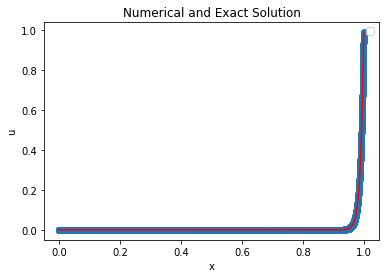

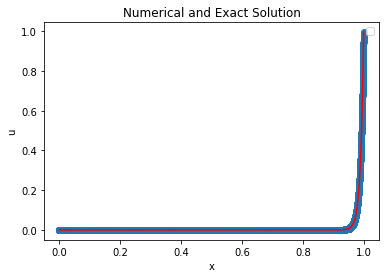

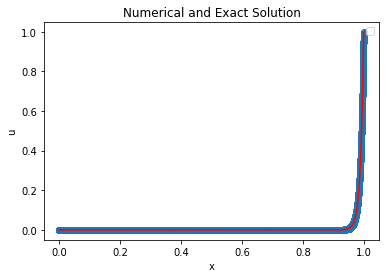

In [ ]:
#Part 6 - Testing second order upwind method - beta > 0
a = 0.
b = 1.
mu = .1
step = [0.0001, 0.0001/2, 0.0001/4]
error_table = pd.DataFrame(index = ['beta', 'h', 'error']).T
for i in [10]: #a positive beta
    for j in range(len(step)):
        beta = step[j]
        temp_u = f_O2upwind(a, b, mu, i, beta)
        
        temp_N = int((b-a)/beta)
        temp_x = np.linspace(a,b,temp_N + 1)
        temp_y = temp_x[1:-1]
        temp_ex = u_ex(temp_y, mu, i)
        
        temp_error = np.max(np.abs(temp_ex - temp_u))
        temp_row = pd.DataFrame([i, beta, temp_error], index = error_table.columns).T
        error_table = error_table.append(temp_row)

        plt.figure(j)
        plt.plot(temp_y, temp_ex, color="red")
        plt.scatter(temp_y, temp_u)
        plt.legend("","")
        plt.title("Numerical and Exact Solution") 
        plt.xlabel("x")
        plt.ylabel("u")

        
#error_table = error_table.dropna(how = 'any')
error_table.loc[:,'Pe'] = (np.abs(error_table.loc[:,'beta']) * error_table.loc[:,'h']) / (2 * mu)
# error_table.loc[:,'% error'] = error_table.loc[:,'error'].div(error_table.groupby('beta')['error'].shift(1))
# error_table.loc[:,'% h'] = error_table.loc[:,'h'].div(error_table.groupby('beta')['h'].shift(1))
error_table

In [ ]:
#Part 6 - Testing second order upwind method - beta > 0
a = 0.
b = 1.
mu = 10

error_table = pd.DataFrame(index = ['beta', 'h', 'error']).T
for i in [1, 10, 100, 1000]:
    for j in [0.1, 0.05, 0.025, 0.01, 0.005]:
        temp_u = f_O2upwind(a, b, mu, i, j)
        
        temp_N = int((b-a)/j)
        temp_x = np.linspace(a,b,temp_N + 1)
        temp_y = temp_x[1:-1]
        temp_ex = u_ex(temp_y, mu, i)
        
        temp_error = np.max(np.abs(temp_ex - temp_u))
        temp_row = pd.DataFrame([i, j, temp_error], index = error_table.columns).T
        error_table = error_table.append(temp_row)

error_table.loc[:,'Pe'] = (np.abs(error_table.loc[:,'beta']) * error_table.loc[:,'h']) / (2 * mu)
# error_table

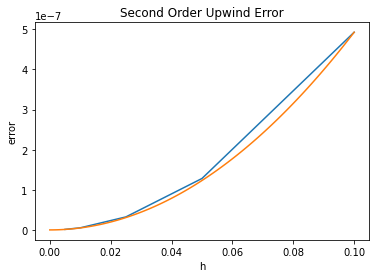

In [ ]:
beta = 1

temp_x = np.linspace(0, max(error_table.loc[[i == beta for i in error_table.beta],'h']), 100)
temp_coef = max(error_table.loc[[i == beta for i in error_table.beta],'error']) / (max(error_table.loc[[i == beta for i in error_table.beta],'h']) ** 2)
temp_y = [temp_coef * (i ** 2) for i in temp_x]
plt.plot(error_table.loc[[i == beta for i in error_table.beta],'h'], error_table.loc[[i == beta for i in error_table.beta],'error'])
plt.title('Second Order Upwind Error')
plt.xlabel("h")
plt.ylabel("error")
plt.plot(temp_x, temp_y)